Geographic Visualization of COVID-19 Data
-------------------------------------------------------------------------------------------------------------------------------

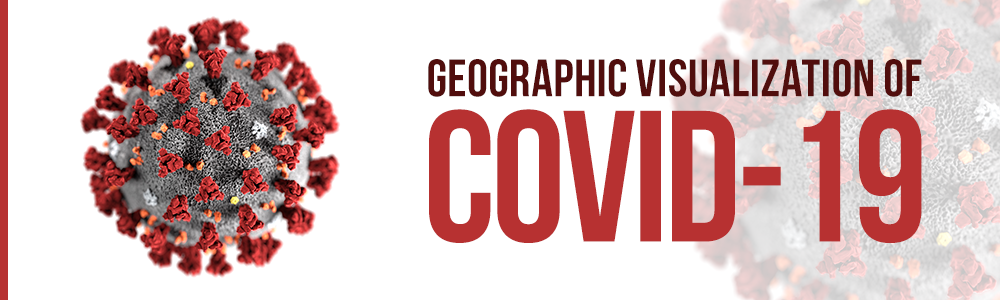

### Table of Contents:

1. [Introduction.](#bullet-1)
2. [Import required libraries.](#bullet-2)
3. [Specify data source url address.](#bullet-3)
4. [Define functions to be used in the project.](#bullet-4)<br>
    4a. [Data Request Function.](#bullet-5)<br>
    4b. [Data Cleaning Functions.](#bullet-6)<br>
    4c. [Data Geolocation Function.](#bullet-7)<br>
    4d. [Data Geovisualization Function.](#bullet-8)<br>
    4e. [Main Function.](#bullet-9)
5. [Run the entire project.](#bullet-10)
6. [BONUS step.](#bullet-11)

### 1: Introduction. <a class="anchor" id="bullet-1"></a>

It is no longer news that visualization of data gives deeper insights and helps understand the trend of a particular observation. Also, it makes data analysis easier has the entire dataset can be presented in a single page.

Due to the ongoing COVID-19 pandemic, I decided to create a geographic visualization on the available data from a statistics website, which details the number of cases, number of deaths, number of active cases, etc, per country. This visualization uses geographic location for each country and displays the essential data as listed above when hovered on.
 
This notebook shows the steps involved from data extraction, data cleaning, creation of coordinates, and visualization on a map.

### 2: Import required libraries. <a class="anchor" id="bullet-2"></a>

Import the required libraries for the data extraction, cleaning and visualization stages.

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
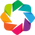

In [4]:
import numpy as np
import pandas as pd
import requests
import IPython
from IPython.display import display

import geopy
from geopy.geocoders import Nominatim
import geoviews as gv
import geoviews.tile_sources as gvts
from geoviews import opts
import bokeh
from bokeh.models import HoverTool

gv.extension('bokeh', 'matplotlib')

In [7]:
print('numpy==',np.__version__)
print('pandas==',pd.__version__)
print('requests==',requests.__version__)
print('IPython==',IPython.__version__)
print('geopy==',geopy.__version__)
print('geoviews==',gv.__version__)
print('bokeh==',bokeh.__version__)

numpy== 1.16.4
pandas== 0.24.2
requests== 2.22.0
IPython== 7.6.1
geopy== 1.21.0
geoviews== 1.6.6
bokeh== 1.2.0


### 3: Specify data source url address. <a class="anchor" id="bullet-3"></a>

For this project, we will be focusing on the most visited website for COVID-19 resources based on https://www.similarweb.com/coronavirus#keywords-and-websites.
<br>
A recent statistics shown below;
     
   1. <a href="https://www.worldometers.info/coronavirus/" target="_blank">Worldometers</a> with 31.4 million visits on 04/22/2020.
   2. <a href="https://cdc.gov/" target="_blank">Centers for Disease Control & Prevention</a> with 5.5 million visits on 04/22/2020.
   3. <a href="https://who.int/" target="_blank">World Health Organization</a> with 4.1 million visits on 04/22/2020.
   4. <a href="https://ecdc.europa.eu/" target="_blank">European Centre for Disease Prevention & Control</a> with 170k visits on 04/22/2020.

In [14]:
COVID_19_URL = 'https://www.worldometers.info/coronavirus/'

### 4: Define functions to be used in the project. <a class="anchor" id="bullet-4"></a>

We are going to be defining functions for data requests/extracts, data cleaning, data geolocation, and the eventual data 
visualization.

#### 4a: Data Request Function: <a class="anchor" id="bullet-5"></a>

In [15]:
def data_request(url):
    '''
    This function requests content from the specified url and extracts the data table into a dataframe.
    '''
    
    try:
        html_request = requests.get(url, headers={'Cache-Control': 'no-cache', 'Pragma': 'no-cache'})
    except Exception as e:
        raise e
    
    html = html_request.content
    table = pd.read_html(html)[-1]
    
    return table

#### 4b: Data Cleaning Functions: <a class="anchor" id="bullet-6"></a>

In [16]:
def data_cleaner(table):
    '''
    This function serves to rid the dataframe of incorrect country names, total/sum values of the columns, and NaN values.
    '''
    
    #Drop the world and total rows. Upon intial checking, they were identified as rows 213 and 0 respectively.
    table = table.drop([213, 0])
    unneededColumns = range(7, 12)
    edited_table = table.drop(table.columns[unneededColumns], axis = 1)
    
    
    #replace NaN values with zeros
    corrected_table = edited_table.fillna(0)
    
    
    #modify the country names
    old_values = ['CAR', 'Georgia', 'UAE']
    new_values = ['Central African Republic', 'Republic of Georgia', 'United Arab Emirates']
    corrected_country = corrected_table.replace(old_values, new_values)
    corrected_table = corrected_country.sort_values(by = ['Country,Other'])

    final_table = corrected_table.rename(columns={
        'Country,Other' : 'Country', 'TotalCases': 'Total Cases', 'TotalDeaths': 'Total Deaths', 
        'NewCases': 'New Cases', 'NewDeaths': 'New Deaths', 'TotalRecovered': 'Total Recovered',
        'ActiveCases': 'Active Cases'})
    
    
    #convert specific columns t lists
    country_list = final_table['Country'].to_list()
    new_cases_list = final_table['New Cases'].to_list()
    new_deaths_list = final_table['New Deaths'].to_list()
    
    #preview the table and lists
    #print(country_list, '\n')
    #print(new_cases_list, '\n')
    #print(new_deaths_list, '\n')
    
    
    return final_table, country_list, new_cases_list, new_deaths_list

In [17]:
def remove_signs(signedList):
    '''
    This step involves modification of the row values of the New Cases and New Deaths.
    Upon printing the top 5 rows using .heads() attribute of the pandas library, we notice '+' and ',' signs in the values.
    As such, we need to modify these values to show just numbers or integers.
    '''
    #print(signedList, '\n')
    
    unsignedList = []
    
    for each in signedList:
        if type(each) == str:
            each = each.replace(',', '')
            new = int(each[1:])
        else:
            new = each
        unsignedList.append(new)
    
    #print(unsignedList, '\n')
    
    return unsignedList

#### 4c Data Geolocation Function: <a class="anchor" id="bullet-7"></a>

In [18]:
def location(country_list):
    '''
    This step involves creating/extracting the respective geographic locations of the COVID-19 data extracted in step 2.
    This geographic locations, in terms of longitude and latitude, are appended to the final_table dataframe from the
    second step.
    '''
    
    geolocator = Nominatim(user_agent = 'Chrome/80.0.3987.132')

    longitude_list = []
    latitude_list = []

    for each in country_list:
        location = geolocator.geocode(each, timeout = 15)
    
        log = location.longitude
        lat = location.latitude 
        
        longitude_list.append(log)
        latitude_list.append(lat)
 
    return latitude_list, longitude_list

#### 4d: Data Geovisualization Function: <a class="anchor" id="bullet-8"></a>

In [19]:
def plot_geomap(final_table):
    '''
    This step involves creating the geographic visualization using a real-time dataset that gets daily updates.
    '''
    
    #plot the datapoints on the respective geolocations.
    table_plot = gv.Points(final_table, ['Longitude', 'Latitude'], ['Country', 'Total Cases', 'Total Deaths',
                               'New Cases', 'New Deaths', 'Total Recovered', 'Active Cases'])

    
    #create the hover tools to be shown if datapoint is selected on the map.
    tooltips = [('Country', '@Country'), ('Total Cases', '@Total Cases'),
            ('Total Deaths', '@Total Deaths'), ('New Cases', '@New Cases'),
            ('New Deaths', '$New Deaths'), ('Total Recovered', '$Total Recovered'),\
            ('Active Cases', '$Active Cases')]

    HoverTool(tooltips = tooltips)

    
    #plot the map visualization including the hover tool
    covid_plot = (gvts.CartoDark * table_plot).opts(
        opts.Points(global_extent=True, width=900, height=600, alpha=0.8, hover_line_color='black',\
                line_color='black', xaxis=None, yaxis=None, tools=['hover'], size = 10,\
                color='red', hover_fill_color='green', hover_fill_alpha=0.8, toolbar='above'))

    
    return covid_plot

#### 4e: Main Function: <a class="anchor" id="bullet-9"></a>

In [20]:
def main():
    '''
    A combination of all the created functions to visualize the geographical map of COVID-19 data.
    '''
    #request and clean data
    data_table = data_request(url=COVID_19_URL)
    
    data = data_cleaner(data_table)
    
    #assign data output to lists and dataframe
    final_table = data[0]
    lat_long = location(data[1])
    new_cases_list = remove_signs(data[2])
    new_deaths_list = remove_signs(data[3])
    
    #append lists to the dataframe
    final_table['Latitude'] = lat_long[0]
    final_table['Longitude'] = lat_long[1]
    final_table['New Cases'] = new_cases_list
    final_table['New Deaths'] = new_deaths_list
    
    
    
    #plot visualization
    plot = plot_geomap(final_table)
    display(plot)

### 5: Run the entire project. <a class="anchor" id="bullet-10"></a>

This step runs the main function, executes the already defined functions.

In [21]:
if __name__ == '__main__':
    main()

:Overlay
   .WMTS.I   :WMTS   [Longitude,Latitude]
   .Points.I :Points   [Longitude,Latitude]   (Country,Total Cases,Total Deaths,New Cases,New Deaths,Total Recovered,Active Cases)

### 6: BONUS step. <a class="anchor" id="bullet-11"></a>

The step involves exporting the final_table to a CSV file for future reference, if required.

In [28]:
data_table = data_request(url=COVID_19_URL)    
data = data_cleaner(data_table)
final_table = data_cleaner(data_table)[0]

#display top 5 countries
display(final_table.sort_values(by = ['Total Cases'], ascending = False).head())

#display bottom 5 countries
display(final_table.sort_values(by = ['Total Cases'], ascending = False).tail())

if True:
    final_table.sort_values(by = ['Total Cases'], ascending = False).to_csv('corona_virus_data_extract.csv')
    print('\nCOVID-19 data successfully saved as CSV file.')

,Country,Total Cases,New Cases,Total Deaths,New Deaths,Total Recovered,Active Cases
2,USA,848717,"+29,973",47659.0,"+2,341",84050.0,717008
3,Spain,208389,"+4,211",21717.0,+435,85915.0,100757
4,Italy,187327,"+3,370",25085.0,+437,54543.0,107699
5,France,159877,"+1,827",21340.0,+544,40657.0,97880
6,Germany,150648,"+2,195",5315.0,+229,99400.0,45933


,Country,Total Cases,New Cases,Total Deaths,New Deaths,Total Recovered,Active Cases
209,South Sudan,4,0,0.0,0,0.0,4
208,Sao Tome and Principe,4,0,0.0,0,0.0,4
210,Anguilla,3,0,0.0,0,1.0,2
212,Yemen,1,0,0.0,0,0.0,1
211,Saint Pierre Miquelon,1,0,0.0,0,0.0,1



COVID-19 data successfully saved as CSV file.
